In [1]:
# Import the dependencies

import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Define directory containing the csv files
dir_path = Path("../Resources")

# create an empty list to hold the dataframes 
dfs = []

# loop through each file in the directory
for file in os.listdir(dir_path):
    # check if the file is a csv file
    if file.endswith(".csv"):
        # extract the ticker symbol from the file name (assuming the file name is the ticker symbol)
        ticker = file.replace(".csv", "")
        # Read the file into a DataFrame
        stocks_df = pd.read_csv(dir_path / file)
        # Add a column to the DataFrame to store the ticker symbol
        stocks_df["Ticker"] = ticker
        # add the dataframe to the list
        dfs.append(stocks_df)
        
# concatenate the dataframes in the list
combined_stocks_df = pd.concat(dfs, ignore_index=True)

# Display the combined DataFrame to verify
print(combined_stocks_df.head())

# change the type in 'date' column to datetime
combined_stocks_df["Date"] = pd.to_datetime(combined_stocks_df["Date"])

# Filter the data for the last 20 years from today
twenty_years_ago = pd.Timestamp.today() - pd.DateOffset(years=20)
stocks_data_filtered = combined_stocks_df[combined_stocks_df["Date"] >= twenty_years_ago]

print(stocks_data_filtered.head())
print(stocks_data_filtered.tail())

# List of specific stocks to analyze
stocks_to_analyze = ['BKNG', 'KHC', 'PEP', 'TCOM']

# Initialize dictionaries to hold the MSE and predictions for each stock symbol
mse_dict = {}
predictions_dict = {}

# Iterate through each stock in the list of specific stocks
for stock in stocks_to_analyze:
    # Select the stock's data
    stock_data = stocks_data_filtered[stocks_data_filtered["Ticker"] == stock]
    
    # Display the selected stock data
    print(f"Selected stock data for {stock}:")
    print(stock_data.head())
    
    # Set the date as the index
    stock_data.set_index("Date", inplace=True)
    
    # Define a feature in the data for previous date closing prices
    stock_data["Previous Day Close"] = stock_data["Close"].shift(1)
    
    # Define a feature in the data for the volume
    stock_data["Volume Difference"] = stock_data["Volume"].diff()
    
    # Drop rows with NaN values
    stock_data = stock_data.dropna()
    
    # Define the features (X) and the target (y) variables for training purposes
    X = stock_data[["Previous Day Close", "Volume Difference"]]
    y = stock_data["Close"].values.reshape(-1, 1) 
    
    # Split the data into training and testing sets chronologically
    split = int(0.7 * len(X))
    X_train = X[: split]
    X_test = X[split:]
    y_train = y[: split]
    y_test = y[split:]
    
    # Normalize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define the neural network model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model with epochs
    model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)
    
    # Make predictions using the testing data
    predictions = model.predict(X_test_scaled)
    
    # Calculate the mean_squared_error on the testing data
    mse = mean_squared_error(y_test, predictions)
    print(f"MSE for {stock}: {mse}")
    
    # Store the MSE in the dictionary
    mse_dict[stock] = mse
    
    # Make a prediction for the values of the stock over the next year starting from the last date in the dataset
    # Create a dataframe to hold the predictions
    future_dates = pd.date_range(start=stock_data.index[-1], periods=120, freq='M')
    future_dates_df = pd.DataFrame(future_dates, columns=["Date"])
    future_dates_df.set_index("Date", inplace=True)
    
    # Initialize previous_close with the last available close value
    previous_close = stock_data["Close"].iloc[-1]
    volume_difference = 0

    # Predict the future values iteratively
    future_closes = []
    for date in future_dates_df.index:
        # prepare the input data for prediction
        input_data = pd.DataFrame({"Previous Day Close": [previous_close], "Volume Difference": [volume_difference]})
        input_data_scaled = scaler.transform(input_data)
        # Make the prediction
        predicted_close = model.predict(input_data_scaled)[0][0]
        # Append the predicted close to the list
        future_closes.append(predicted_close)
        # Update previous_close for the next iteration
        previous_close = predicted_close
    
    # Add the predictions to the dataframe
    future_dates_df["Close"] = future_closes
    
    # Store the predictions in the dictionary
    predictions_dict[stock] = future_dates_df

# Display the predictions for each stock ticker
for stock, future_dates_df in predictions_dict.items():
    print(f"Predictions for {stock}:")
    print(future_dates_df)

# Define the base path as the parent directory of "Notebooks" and "Resources"
base_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Create a directory named "Predictions" within the base path if it doesn't exist
predictions_folder = os.path.join(base_path, "Food and Travel Ten Year Predictions")
if not os.path.exists(predictions_folder):
    os.makedirs(predictions_folder)

# Save the Predictions results to individual files in the "Predictions" folder
for stock, future_dates_df in predictions_dict.items():
    prediction_file_path = os.path.join(predictions_folder, f"predictions_{stock}.csv")
    future_dates_df.to_csv(prediction_file_path)

print(f"Prediction results saved to the folder: {predictions_folder}")

# Create a directory named "MSE" within the base path if it doesn't exist
mse_folder = os.path.join(base_path, "Food and Travel Ten Year MSE Output")
if not os.path.exists(mse_folder):
    os.makedirs(mse_folder)

# Define the path to save the MSE results file
mse_file_path = os.path.join(mse_folder, "mse_results.csv")

# Save the MSE results to a file in the "MSE" folder
mse_df = pd.DataFrame(list(mse_dict.items()), columns=["Stock Ticker", "Mean Squared Error"])
mse_df.to_csv(mse_file_path, index=False)

print(f"MSE results saved to: {mse_file_path}")


2024-06-09 10:31:07.511395: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_7636/2215315752.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_stocks_df = pd.concat(dfs, ignore_index=True)


         Date  Open      High       Low     Close  Adj Close     Volume Ticker
0  1990-02-16   0.0  0.079861  0.073785  0.077257   0.052392  940636800   CSCO
1  1990-02-20   0.0  0.079861  0.074653  0.079861   0.054158  151862400   CSCO
2  1990-02-21   0.0  0.078993  0.075521  0.078125   0.052980   70531200   CSCO
3  1990-02-22   0.0  0.081597  0.078993  0.078993   0.053569   45216000   CSCO
4  1990-02-23   0.0  0.079861  0.078125  0.078559   0.053275   44697600   CSCO
           Date       Open       High        Low      Close  Adj Close  \
3609 2004-06-10  23.670000  23.830000  23.480000  23.820000  16.153521   
3610 2004-06-14  23.530001  23.660000  23.080000  23.320000  15.814437   
3611 2004-06-15  23.500000  23.940001  23.430000  23.639999  16.031448   
3612 2004-06-16  23.760000  23.969999  23.700001  23.879999  16.194208   
3613 2004-06-17  23.450001  23.590000  23.190001  23.360001  15.841574   

        Volume Ticker  
3609  35949900   CSCO  
3610  44958400   CSCO  
3611  608

/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_7636/2215315752.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Previous Day Close"] = stock_data["Close"].shift(1)
/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_7636/2215315752.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Volume Difference"] = stock_data["Volume"].diff()
/Users/paulettepetracco/Bootcamp_Code_Challenges/GH_Repositories/Project_4/.venv/lib/python3.10/site-packages/keras/src/layers/cor

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 339762.2812 - val_loss: 2574843.7500
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 345475.5312 - val_loss: 2440138.2500
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 305247.4375 - val_loss: 1998360.6250
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 231621.5156 - val_loss: 1245740.3750
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124692.8047 - val_loss: 487588.3750
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46083.6289 - val_loss: 102250.7578
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11615.2510 - val_loss: 12601.8057
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3596.1511 - val_loss: 1539.6976
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1546.5399 - val_loss: 668.3047
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 899.0425 - val_loss: 635.5125
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 760.7178 - val

/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_7636/2215315752.py:117: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=stock_data.index[-1], periods=120, freq='M')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_7636/2215315752.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Previous Day Close"] = stock_data["Close"].shift(1)
/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_7636/2215315752.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Volume Difference"] = stock_data["Volume"].diff()
/Users/paulettepetracco/Bootcamp_Code_Challenges/GH_Repositories/Project_4/.venv/lib/python3.10/site-packages/keras/src/layers/cor

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4347.9478 - val_loss: 1195.4626
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4239.8179 - val_loss: 936.8854
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3735.4849 - val_loss: 504.3254
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2721.5010 - val_loss: 162.8923
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1583.1313 - val_loss: 55.2338
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 549.4987 - val_loss: 37.9255
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 233.4179 - val_loss: 43.9200
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136.9364 - val_loss: 56.9323
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148.1880 - val_loss: 54.8952
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.5004 - val_loss: 52.0919
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48.4973 - val_loss: 47.1212
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_7636/2215315752.py:117: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=stock_data.index[-1], periods=120, freq='M')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_7636/2215315752.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Previous Day Close"] = stock_data["Close"].shift(1)
/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_7636/2215315752.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Volume Difference"] = stock_data["Volume"].diff()
/Users/paulettepetracco/Bootcamp_Code_Challenges/GH_Repositories/Project_4/.venv/lib/python3.10/site-packages/keras/src/layers/cor

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4742.0762 - val_loss: 10465.3691
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3742.3767 - val_loss: 6742.5957
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1334.4418 - val_loss: 1724.5879
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 412.3630 - val_loss: 63.7632
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 169.9791 - val_loss: 104.3771
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 68.7112 - val_loss: 135.4594
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 49.1162 - val_loss: 107.7072
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37.7422 - val_loss: 88.9394
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.0479 - val_loss: 65.2538
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13.6490 - val_loss: 53.1287
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.2773 - val_loss: 46.4147
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_7636/2215315752.py:117: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=stock_data.index[-1], periods=120, freq='M')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_7636/2215315752.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Previous Day Close"] = stock_data["Close"].shift(1)
/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_7636/2215315752.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Volume Difference"] = stock_data["Volume"].diff()
/Users/paulettepetracco/Bootcamp_Code_Challenges/GH_Repositories/Project_4/.venv/lib/python3.10/site-packages/keras/src/layers/cor

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 242.0794 - val_loss: 1461.5782
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122.2288 - val_loss: 152.5923
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.6639 - val_loss: 9.5362
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0123 - val_loss: 4.4963
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1152 - val_loss: 1.8943
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5145 - val_loss: 1.0363
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6347 - val_loss: 1.1544
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4754 - val_loss: 1.2193
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3550 - val_loss: 1.2647
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3203 - val_loss: 1.2503
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2799 - val_loss: 1.2246
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2989 - val_los

/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_7636/2215315752.py:117: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=stock_data.index[-1], periods=120, freq='M')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

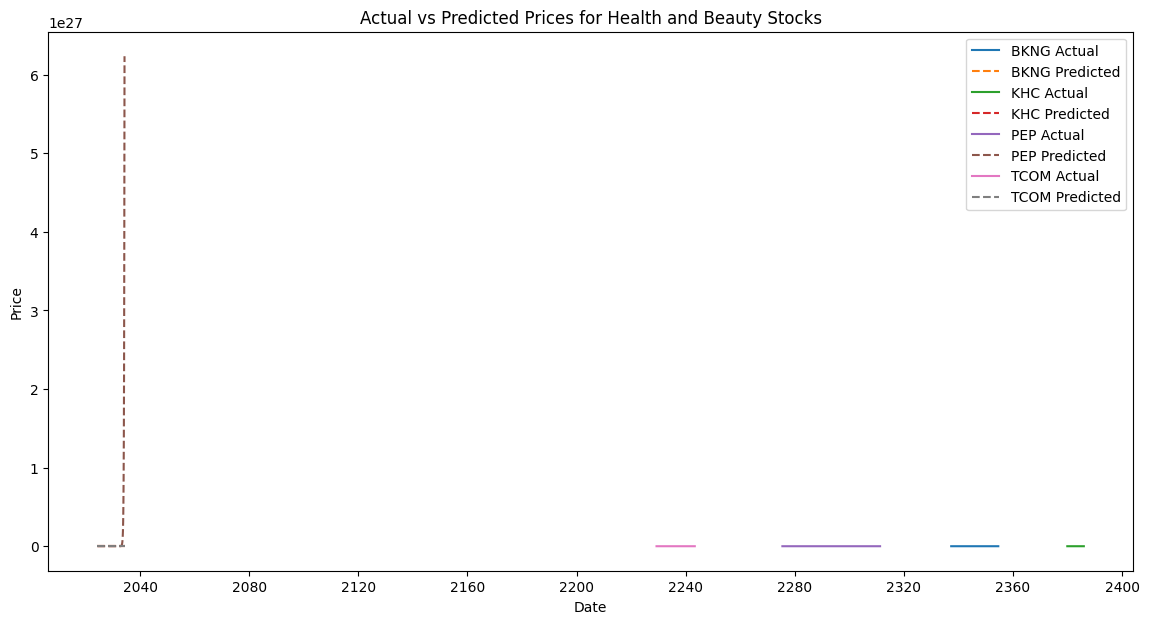

In [2]:
# Function to plot actual vs predicted prices for multiple stocks
def plot_multiple_stocks_actual_vs_predicted(tickers, combined_stocks_df, predictions_dict):
    plt.figure(figsize=(14, 7))
    
    for ticker in tickers:
        # Filter actual prices for the ticker
        actual_prices = combined_stocks_df[combined_stocks_df['Ticker'] == ticker]
        # Get predicted prices for the ticker
        predicted_prices = predictions_dict[ticker]
        
        # Plot actual prices
        plt.plot(actual_prices.index, actual_prices['Close'], label=f"{ticker} Actual")
        # Plot predicted prices
        plt.plot(predicted_prices.index, predicted_prices['Close'], linestyle='dashed', label=f"{ticker} Predicted")
    
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("Actual vs Predicted Prices for Health and Beauty Stocks")
    plt.legend()
    plt.show()

# List of tickers to compare
tickers = ['BKNG', 'KHC', 'PEP', 'TCOM']

# Plot the actual vs predicted prices for the specified tickers
plot_multiple_stocks_actual_vs_predicted(tickers, combined_stocks_df, predictions_dict)

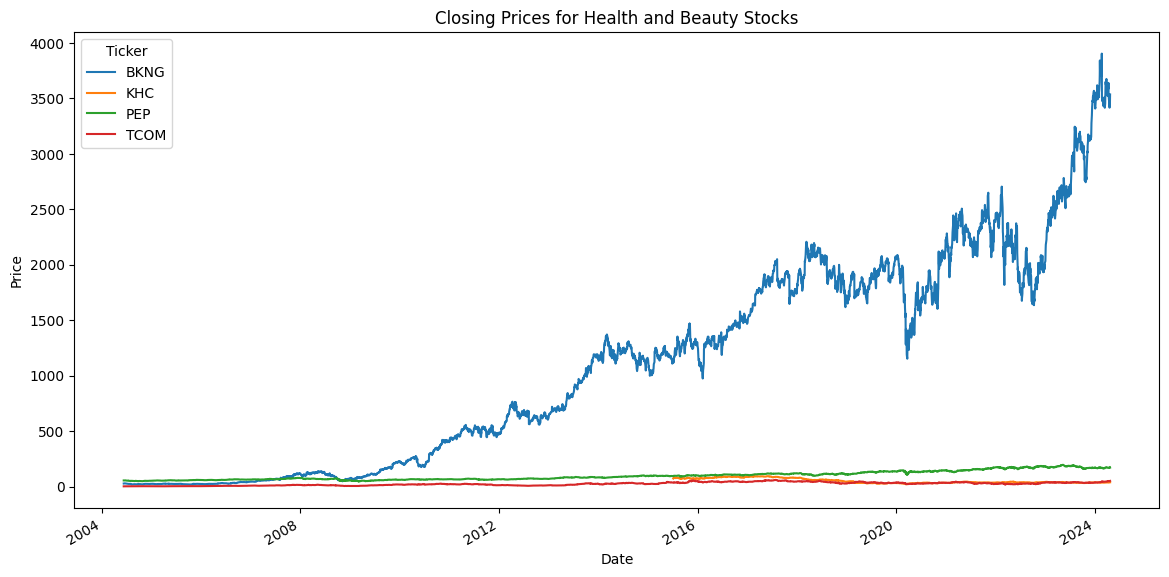

In [3]:
# create a line graph with multiple stocks: BIIB, GILD, INCY, VRTX
# Filter the data for the last 15 years from today
twenty_years_ago = pd.Timestamp.today() - pd.DateOffset(years=20)
stocks_data_filtered = combined_stocks_df[combined_stocks_df["Date"] >= twenty_years_ago] 

# Define the list of tickers to plot
tickers = ['BKNG', 'KHC', 'PEP', 'TCOM']

# Filter the data for the specified tickers
filtered_data = stocks_data_filtered[stocks_data_filtered["Ticker"].isin(tickers)]

# Pivot the data to have the tickers as columns
pivoted_data = filtered_data.pivot(index="Date", columns="Ticker", values="Close")

# Plot the data
pivoted_data.plot(figsize=(14, 7))
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Closing Prices for Health and Beauty Stocks")
plt.show()

# Function to plot the actual and predicted prices for a stock
def plot_actual_vs_predicted(ticker, historical_df, predictions_df):
    plt.figure(figsize=(14, 7))
    plt.plot(historical_df.index, historical_df['Close'], label="Actual Prices")
    plt.plot(predictions_df.index, predictions_df['Close'], label="Predicted Prices", linestyle='dashed')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"Actual vs Predicted Prices for {ticker}")
    plt.legend()
    plt.show()

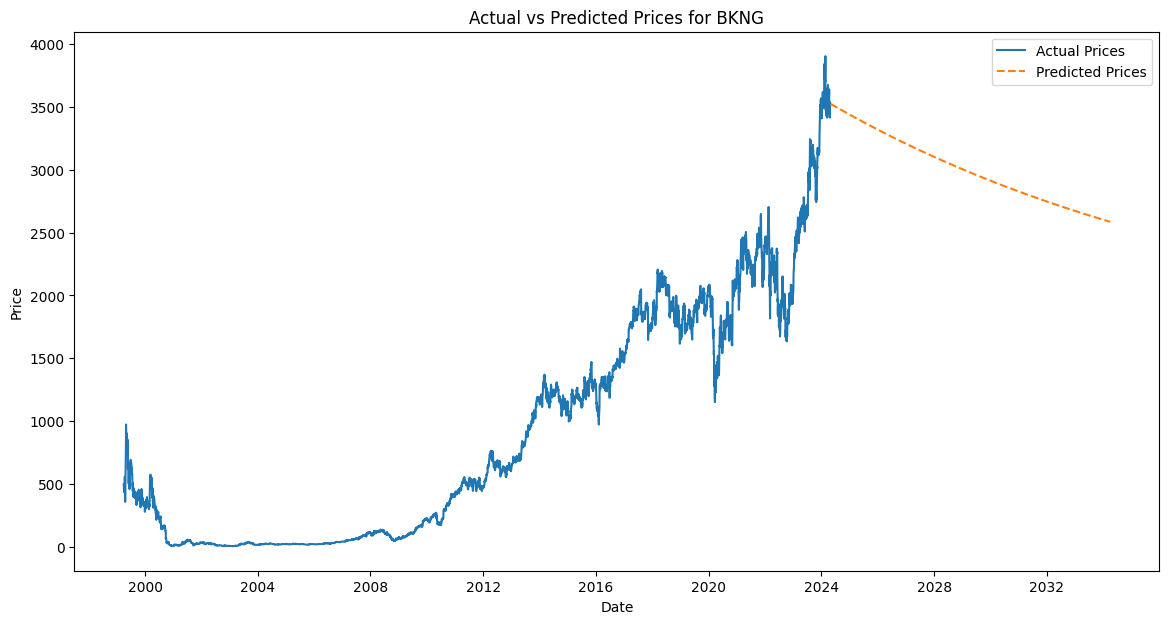

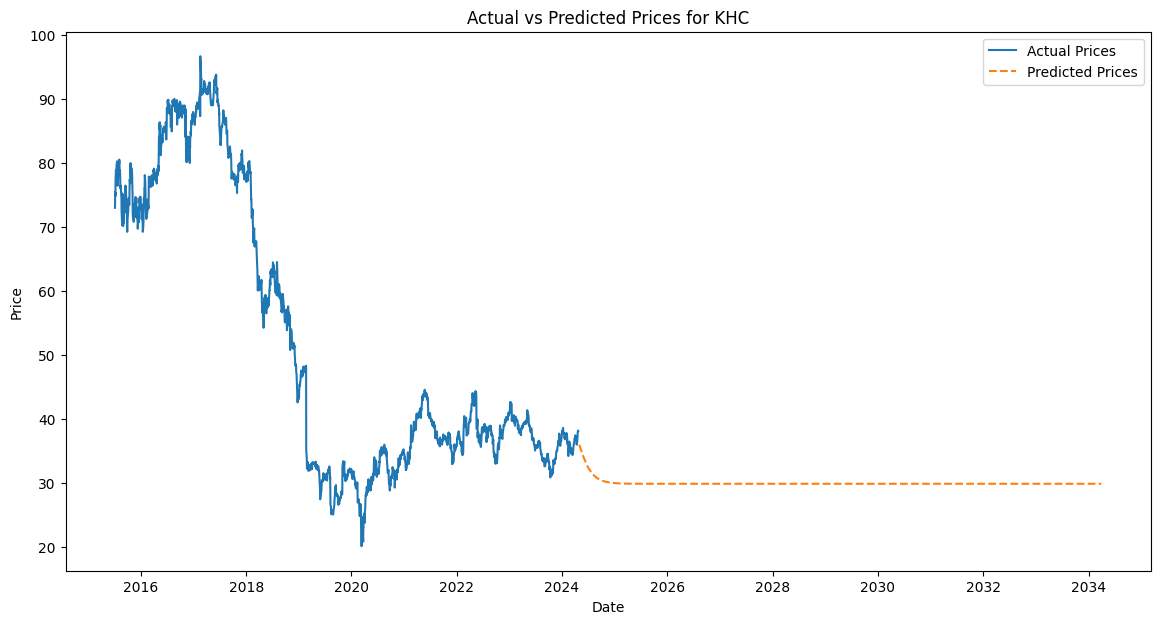

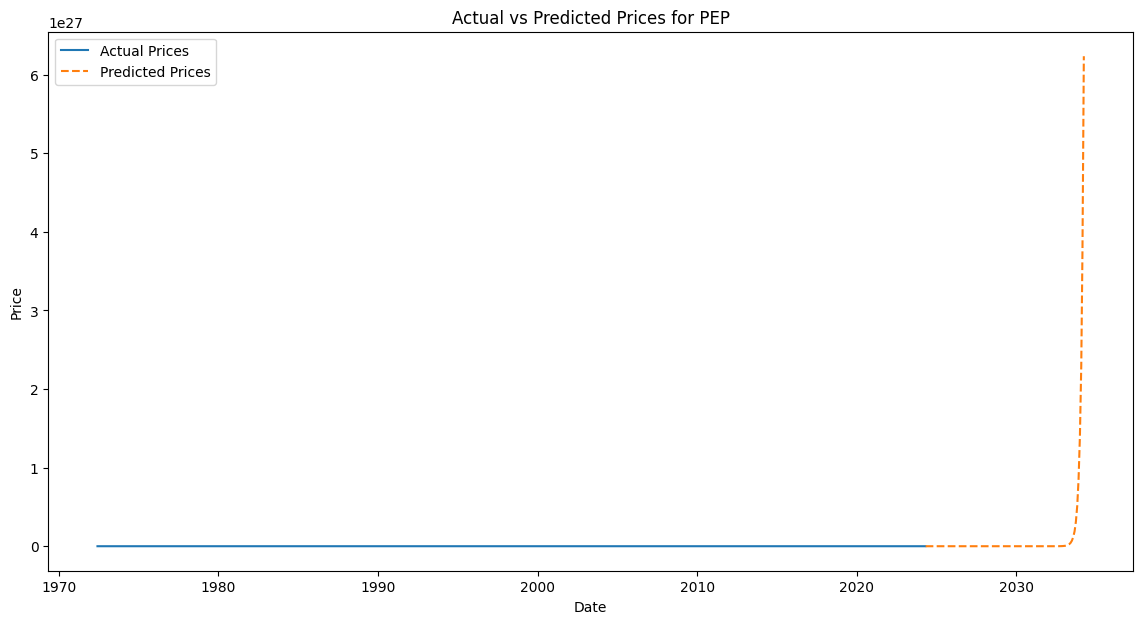

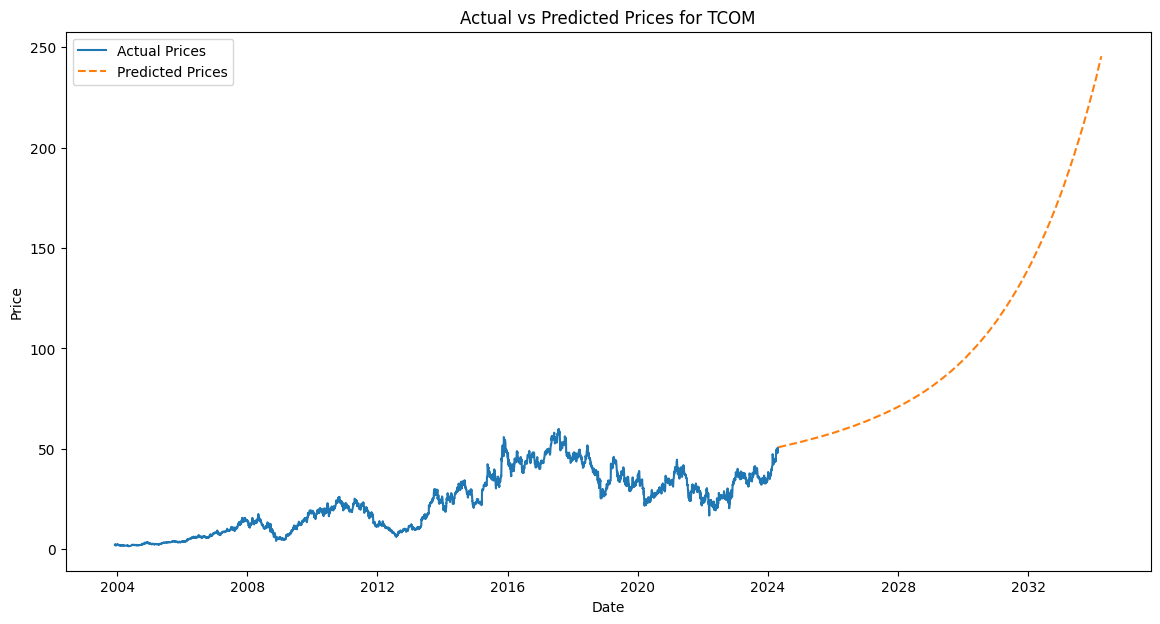

In [4]:
# create a line graph with bio stocks: ALIGN, LULU, PTON, ULTA for predicted prices.
# Define the list of tickers to plot
tickers = ['BKNG', 'KHC', 'PEP', 'TCOM']

# Plot the actual vs predicted prices for the specified tickers
for ticker in tickers:
    # Get the historical data for the stock
    historical_data = combined_stocks_df[combined_stocks_df["Ticker"] == ticker]
    historical_data.set_index("Date", inplace=True)
    
    # Get the predicted prices for the stock
    predicted_data = predictions_dict[ticker]
    
    # Plot the actual vs predicted prices
    plot_actual_vs_predicted(ticker, historical_data, predicted_data)
    
# Function to plot the actual and predicted prices for a stock
def plot_actual_vs_predicted(ticker, historical_df, predictions_df):
    plt.figure(figsize=(14, 7))
    plt.plot(historical_df.index, historical_df['Close'], label="Actual Prices")
    plt.plot(predictions_df.index, predictions_df['Close'], label="Predicted Prices", linestyle='dashed')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"Actual vs Predicted Prices for {ticker}")
    plt.legend()
    plt.show()